# 引言

文本分类是商业问题中常见的自然语言处理任务，目标是自动将文本文件分到一个或多个已定义好的类别中。文本分类的一些例子如下：


    分析社交媒体中的大众情感

    鉴别垃圾邮件和非垃圾邮件

    自动标注客户问询

    将新闻文章按主题分类

In [1]:
#导入数据集预处理、特征工程和模型训练所需的库

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import decomposition, ensemble


import pandas, xgboost, numpy, textblob, string

from keras.preprocessing import text, sequence

from keras import layers, models, optimizers

Using TensorFlow backend.


一、准备数据集


在本文中，我使用亚马逊的评论数据集，它可以从这个链接下载：


    https://gist.github.com/kunalj101/ad1d9c58d338e20d09ff26bcc06c4235


这个数据集包含3.6M的文本评论内容及其标签，我们只使用其中一小部分数据。首先，将下载的数据加载到包含两个列（文本和标签）的pandas的数据结构（dataframe）中。




In [2]:
#加载数据集

data = open('data/corpus').read()

labels, texts = [], []

for i, line in enumerate(data.split("\n")):

    content = line.split()
    
    #print(content)
    #print(content[1])

    labels.append(content[0])

    texts.append(content[1])


#创建一个dataframe，列名为text和label

trainDF = pandas.DataFrame()

trainDF['text'] = texts

trainDF['label'] = labels


#print texts[:10],labels[:10]

每一个content的数据是这样的：
['__label__2', 'Stuning', 'even', 'for', 'the', 'non-gamer:', 'This', 'sound', 'track', 'was', 'beautiful!', 'It', 'paints', 'the', 'senery', 'in', 'your', 'mind', 'so', 'well', 'I', 'would', 'recomend', 'it', 'even', 'to', 'people', 'who', 'hate', 'vid.', 'game', 'music!', 'I', 'have', 'played', 'the', 'game', 'Chrono', 'Cross', 'but', 'out', 'of', 'all', 'of', 'the', 'games', 'I', 'have', 'ever', 'played', 'it', 'has', 'the', 'best', 'music!', 'It', 'backs', 'away', 'from', 'crude', 'keyboarding', 'and', 'takes', 'a', 'fresher', 'step', 'with', 'grate', 'guitars', 'and', 'soulful', 'orchestras.', 'It', 'would', 'impress', 'anyone', 'who', 'cares', 'to', 'listen!', '^_^']

>值得注意的是：texts里边存的是每个样本的第一个单词，我不知道这个是作者故意的还是疏忽？

texts[:10]和labels[:10]的数据是这样的：
['Stuning', 'The', 'Amazing!:', 'Excellent', 'Remember,', 'an', 'Buyer', 'Glorious', 'A', 'Whispers'] 
['__label__2', '__label__2', '__label__2', '__label__2', '__label__2', '__label__2', '__label__1', '__label__2', '__label__2', '__label__2']


接下来，我们将数据集分为训练集和验证集，这样我们可以训练和测试分类器。另外，我们将编码我们的目标列，以便它可以在机器学习模型中使用:

In [3]:
#将数据集分为训练集和验证集

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

#print(trainDF,train_x,valid_x)
#将trainDF（10000）个样本和标签打乱拆分成train_x（7500）个,valid_x（2500）个

# label编码为目标变量

encoder = preprocessing.LabelEncoder()

#print train_y
train_y = encoder.fit_transform(train_y)
#print train_y
#将label编码由3451    __label__1 6228    __label__2形式为[0 1 0 。。。]形式

valid_y = encoder.fit_transform(valid_y)

二、特征工程


接下来是特征工程，在这一步，原始数据将被转换为特征向量，另外也会根据现有的数据创建新的特征。为了从数据集中选出重要的特征，有以下几种方式：


    1.计数向量作为特征

    2.TF-IDF向量作为特征

        2.1单个词语级别

        2.2多个词语级别（N-Gram）

        2.3词性级别

    3.词嵌入作为特征

    4.基于文本/NLP的特征

    5.主题模型作为特征

2.1 计数向量作为特征


计数向量是数据集的矩阵表示，其中每行代表来自语料库的文档，每列表示来自语料库的术语，并且每个单元格表示特定文档中特定术语的频率计数：

In [4]:
#创建一个向量计数器对象

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

count_vect.fit(trainDF['text'])

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

In [5]:
#使用向量计数器对象转换训练集和验证集

xtrain_count =  count_vect.transform(train_x)


xvalid_count =  count_vect.transform(valid_x)

2.2 TF-IDF向量作为特征


TF-IDF的分数代表了词语在文档和整个语料库中的相对重要性。TF-IDF分数由两部分组成：第一部分是计算标准的词语频率（TF），第二部分是逆文档频率（IDF）。其中计算语料库中文档总数除以含有该词语的文档数量，然后再取对数就是逆文档频率。


TF(t)=（该词语在文档出现的次数）/（文档中词语的总数）

IDF(t)= log_e（文档总数/出现该词语的文档总数）

TF-IDF向量可以由不同级别的分词产生（单个词语，词性，多个词（n-grams））


    词语级别TF-IDF：矩阵代表了每个词语在不同文档中的TF-IDF分数。

    N-gram级别TF-IDF: N-grams是多个词语在一起的组合，这个矩阵代表了N-grams的TF-IDF分数。

    词性级别TF-IDF：矩阵代表了语料中多个词性的TF-IDF分数。

In [6]:
#词语级tf-idf

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

tfidf_vect.fit(trainDF['text'])

xtrain_tfidf =  tfidf_vect.transform(train_x)

xvalid_tfidf =  tfidf_vect.transform(valid_x)


# ngram 级tf-idf

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

tfidf_vect_ngram.fit(trainDF['text'])

xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)

xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)


#词性级tf-idf

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

tfidf_vect_ngram_chars.fit(trainDF['text'])

xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 

xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

2.3 词嵌入


词嵌入是使用稠密向量代表词语和文档的一种形式。向量空间中单词的位置是从该单词在文本中的上下文学习到的，词嵌入可以使用输入语料本身训练，也可以使用预先训练好的词嵌入模型生成，词嵌入模型有：Glove, FastText,Word2Vec。它们都可以下载，并用迁移学习的方式使用。想了解更多的词嵌入资料，可以访问：


    https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/


接下来介绍如何在模型中使用预先训练好的词嵌入模型，主要有四步：


1. 加载预先训练好的词嵌入模型

2. 创建一个分词对象

3. 将文本文档转换为分词序列并填充它们

4. 创建分词和各自嵌入的映射

In [7]:
#加载预先训练好的词嵌入向量

embeddings_index = {}

for i, line in enumerate(open('/home/kuo/data/wiki-news-300d-1M.vec')):

    values = line.split()
#     if i == 0:
#         print values  #['999994', '300']

    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')


#创建一个分词器

token = text.Tokenizer()

token.fit_on_texts(trainDF['text'])

word_index = token.word_index


#将文本转换为分词序列，并填充它们保证得到相同长度的向量

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)

valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)


#创建分词嵌入映射

embedding_matrix = numpy.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():

    embedding_vector = embeddings_index.get(word)

if embedding_vector is not None:

    embedding_matrix[i] = embedding_vector

print len(train_seq_x[0]) 

70

print (train_seq_x[0])


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 220]

print len(embedding_matrix[0])

300

2.4 基于文本/NLP的特征


创建许多额外基于文本的特征有时可以提升模型效果。比如下面的例子：


    文档的词语计数—文档中词语的总数量

    文档的词性计数—文档中词性的总数量

    文档的平均字密度--文件中使用的单词的平均长度

    完整文章中的标点符号出现次数--文档中标点符号的总数量

    整篇文章中的大写次数—文档中大写单词的数量

    完整文章中标题出现的次数—文档中适当的主题（标题）的总数量

    词性标注的频率分布

        名词数量

        动词数量

        形容词数量

        副词数量

        代词数量


这些特征有很强的实验性质，应该具体问题具体分析。

In [11]:
trainDF['char_count'] = trainDF['text'].apply(len)

trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))

trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)

trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 

trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


trainDF['char_count'] = trainDF['text'].apply(len)

trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))

trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)

trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 

trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}


#检查和获得特定句子中的单词的词性标签数量

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))

trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))

trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))

trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))

trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

2.5 主题模型作为特征


主题模型是从包含重要信息的文档集中识别词组（主题）的技术，我已经使用LDA生成主题模型特征。LDA是一个从固定数量的主题开始的迭代模型，每一个主题代表了词语的分布，每一个文档表示了主题的分布。虽然分词本身没有意义，但是由主题表达出的词语的概率分布可以传达文档思想。如果想了解更多主题模型，请访问：


    https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/


我们看看主题模型运行过程：


In [13]:
#训练主题模型

lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)

X_topics = lda_model.fit_transform(xtrain_count)

topic_word = lda_model.components_ 

vocab = count_vect.get_feature_names()


#可视化主题模型

n_top_words = 10

topic_summaries = []

for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

三、建模


文本分类框架的最后一步是利用之前创建的特征训练一个分类器。关于这个最终的模型，机器学习中有很多模型可供选择。我们将使用下面不同的分类器来做文本分类：


    朴素贝叶斯分类器

    线性分类器

    支持向量机（SVM）

    Bagging Models

    Boosting Models

    浅层神经网络

    深层神经网络

        卷积神经网络（CNN）

        LSTM

        GRU

        双向RNN

        循环卷积神经网络（RCNN）

        其它深层神经网络的变种


接下来我们详细介绍并使用这些模型。下面的函数是训练模型的通用函数，它的输入是分类器、训练数据的特征向量、训练数据的标签，验证数据的特征向量。我们使用这些输入训练一个模型，并计算准确度。




In [15]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

3.1 朴素贝叶斯


利用sklearn框架，在不同的特征下实现朴素贝叶斯模型。


朴素贝叶斯是一种基于贝叶斯定理的分类技术，并且假设预测变量是独立的。朴素贝叶斯分类器假设一个类别中的特定特征与其它存在的特征没有任何关系。


想了解朴素贝叶斯算法细节可点击：
https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

In [16]:
#特征为计数向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print "NB, Count Vectors: ", accuracy

#特征为词语级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print "NB, WordLevel TF-IDF: ", accuracy

#特征为多个词语级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print "NB, N-Gram Vectors: ", accuracy

#特征为词性级别TF-IDF向量的朴素贝叶斯
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print "NB, CharLevel Vectors: ", accuracy

NB, Count Vectors:  0.6996
NB, WordLevel TF-IDF:  0.6976
NB, N-Gram Vectors:  0.498
NB, CharLevel Vectors:  0.6704


3.2 线性分类器


实现一个线性分类器（Logistic Regression）：Logistic回归通过使用logistic / sigmoid函数估计概率来度量类别因变量与一个或多个独立变量之间的关系。如果想了解更多关于logistic回归，请访问：


    https://www.analyticsvidhya.com/blog/2015/10/basics-logistic-regression/

In [17]:
#特征为计数向量的线性分类器
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print "LR, Count Vectors: ", accuracy

#特征为词语级别TF-IDF向量的线性分类器
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print "LR, WordLevel TF-IDF: ", accuracy

#特征为多个词语级别TF-IDF向量的线性分类器
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print "LR, N-Gram Vectors: ", accuracy

#特征为词性级别TF-IDF向量的线性分类器
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print "LR, CharLevel Vectors: ", accuracy

LR, Count Vectors:  0.7012
LR, WordLevel TF-IDF:  0.6988
LR, N-Gram Vectors:  0.4992
LR, CharLevel Vectors:  0.698


3.3 实现支持向量机模型


支持向量机（SVM）是监督学习算法的一种，它可以用来做分类或回归。该模型提取了分离两个类的最佳超平面或线。如果想了解更多关于SVM，请访问：


    https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

In [19]:
#特征为多个词语级别TF-IDF向量的SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print "SVM, N-Gram Vectors: ", accuracy

SVM, N-Gram Vectors:  0.496


3.4 Bagging Model


实现一个随机森林模型：随机森林是一种集成模型，更准确地说是Bagging model。它是基于树模型家族的一部分。如果想了解更多关于随机森林，请访问：


    https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/

In [21]:
#特征为计数向量的RF
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print "RF, Count Vectors: ", accuracy

#特征为词语级别TF-IDF向量的RF
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print "RF, WordLevel TF-IDF: ", accuracy

RF, Count Vectors:  0.702
RF, WordLevel TF-IDF:  0.6972


3.5 Boosting Model


实现一个Xgboost模型：Boosting model是另外一种基于树的集成模型。Boosting是一种机器学习集成元算法，主要用于减少模型的偏差，它是一组机器学习算法，可以把弱学习器提升为强学习器。其中弱学习器指的是与真实类别只有轻微相关的分类器（比随机猜测要好一点）。如果想了解更多，请访问：


    https://www.analyticsvidhya.com/blog/2016/01/xgboost-algorithm-easy-steps/

In [22]:
#特征为计数向量的Xgboost
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print "Xgb, Count Vectors: ", accuracy

#特征为词语级别TF-IDF向量的Xgboost
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print "Xgb, WordLevel TF-IDF: ", accuracy

#特征为词性级别TF-IDF向量的Xgboost
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print "Xgb, CharLevel Vectors: ", accuracy

Xgb, Count Vectors:  0.6268
Xgb, WordLevel TF-IDF:  0.63
Xgb, CharLevel Vectors:  0.6592


3.6 浅层神经网络


神经网络被设计成与生物神经元和神经系统类似的数学模型，这些模型用于发现被标注数据中存在的复杂模式和关系。一个浅层神经网络主要包含三层神经元-输入层、隐藏层、输出层。如果想了解更多关于浅层神经网络，请访问：


    https://www.analyticsvidhya.com/blog/2017/05/neural-network-from-scratch-in-python-and-r/

In [23]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
print "NN, Ngram Level TF IDF Vectors",  accuracy

Epoch 1/1
7500/7500 [==============================] - 8s - loss: 0.6913     
NN, Ngram Level TF IDF Vectors 0.496


3.7 深层神经网络


深层神经网络是更复杂的神经网络，其中隐藏层执行比简单Sigmoid或Relu激活函数更复杂的操作。不同类型的深层学习模型都可以应用于文本分类问题。

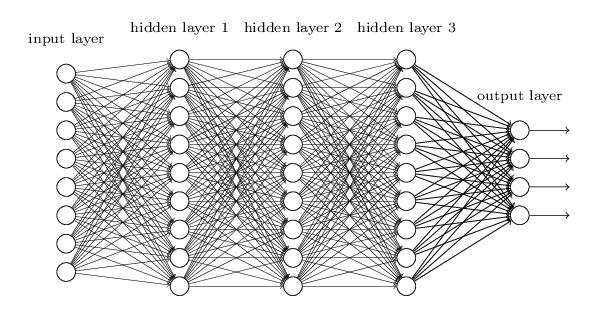

  

  卷积神经网络


卷积神经网络中，输入层上的卷积用来计算输出。本地连接结果中，每一个输入单元都会连接到输出神经元上。每一层网络都应用不同的滤波器（filter）并组合它们的结果。

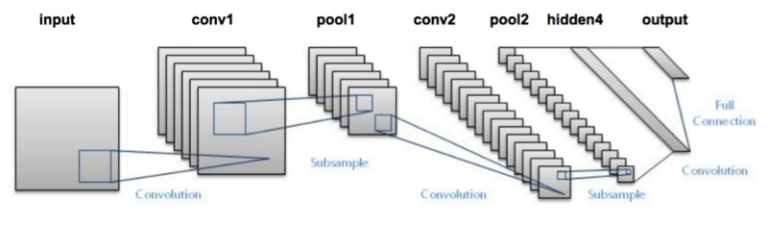

如果想了解更多关于卷积神经网络，请访问：


    https://www.analyticsvidhya.com/blog/2017/06/architecture-of-convolutional-neural-networks-simplified-demystified/

In [24]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print "CNN, Word Embeddings",  accuracy

Epoch 1/1
7500/7500 [==============================] - 22s - loss: 0.6930    
CNN, Word Embeddings 0.496


    循环神经网络-LSTM


与前馈神经网络不同，前馈神经网络的激活输出仅在一个方向上传播，而循环神经网络的激活输出在两个方向传播（从输入到输出，从输出到输入）。因此在神经网络架构中产生循环，充当神经元的“记忆状态”，这种状态使神经元能够记住迄今为止学到的东西。RNN中的记忆状态优于传统的神经网络，但是被称为梯度弥散的问题也因这种架构而产生。这个问题导致当网络有很多层的时候，很难学习和调整前面网络层的参数。为了解决这个问题，开发了称为LSTM（Long Short Term Memory）模型的新型RNN：
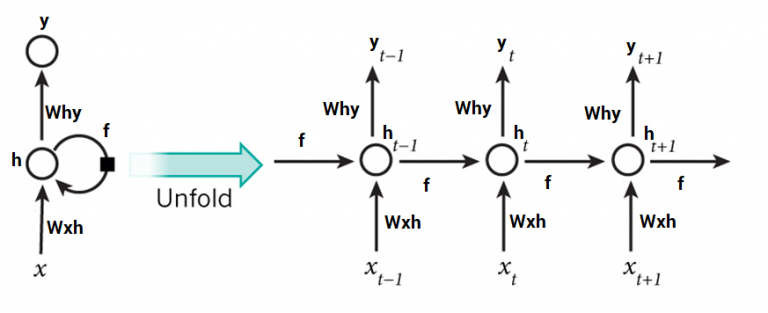
如果想了解更多关于LSTM，请访问：


    https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

In [25]:

def create_rnn_lstm():

    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print "RNN-LSTM, Word Embeddings",  accuracy



Epoch 1/1
7500/7500 [==============================] - 56s - loss: 0.6931    
RNN-LSTM, Word Embeddings 0.496


    循环神经网络-GRU


门控递归单元是另一种形式的递归神经网络,我们在网络中添加一个GRU层来代替LSTM。

In [26]:

def create_rnn_gru():

    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print "RNN-GRU, Word Embeddings",  accuracy



Epoch 1/1
7500/7500 [==============================] - 35s - loss: 0.6930    
RNN-GRU, Word Embeddings 0.496


    双向RNN


RNN层也可以被封装在双向层中，我们把GRU层封装在双向RNN网络中。

In [27]:

def create_bidirectional_rnn():

    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print "RNN-Bidirectional, Word Embeddings",  accuracy



Epoch 1/1
7500/7500 [==============================] - 55s - loss: 0.6932    
RNN-Bidirectional, Word Embeddings 0.496


    循环卷积神经网络


如果基本的架构已经尝试过，则可以尝试这些层的不同变体，如递归卷积神经网络，还有其它变体，比如：


    层次化注意力网络（Sequence to Sequence Models with Attention）

    具有注意力机制的seq2seq（Sequence to Sequence Models with Attention）

    双向循环卷积神经网络

    更多网络层数的CNNs和RNNs

In [28]:

def create_rcnn():

    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print "CNN, Word Embeddings",  accuracy



Epoch 1/1
7500/7500 [==============================] - 18s - loss: 0.6930    
CNN, Word Embeddings 0.496


进一步提高文本分类模型的性能


虽然上述框架可以应用于多个文本分类问题，但是为了达到更高的准确率，可以在总体框架中进行一些改进。例如，下面是一些改进文本分类模型和该框架性能的技巧：


1. 清洗文本：文本清洗有助于减少文本数据中出现的噪声，包括停用词、标点符号、后缀变化等。这篇文章有助于理解如何实现文本分类：


    https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/


2. 组合文本特征向量的文本/NLP特征：特征工程阶段，我们把生成的文本特征向量组合在一起，可能会提高文本分类器的准确率。


模型中的超参数调优：参数调优是很重要的一步，很多参数通过合适的调优可以获得最佳拟合模型，例如树的深层、叶子节点数、网络参数等。


3. 集成模型：堆叠不同的模型并混合它们的输出有助于进一步改进结果。如果想了解更多关于模型集成，请访问：


    https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/

写在最后


本文讨论了如何准备一个文本数据集，如清洗、创建训练集和验证集。使用不同种类的特征工程，比如计数向量、TF-IDF、词嵌入、主题模型和基本的文本特征。然后训练了多种分类器，有朴素贝叶斯、Logistic回归、SVM、MLP、LSTM和GRU。最后讨论了提高文本分类器性能的多种方法。


你从这篇文章受益了吗？可以在下面评论中分享你的观点和看法。


原文链接：https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/


